In [1]:
import numpy as np
import torch
from torchvision.models import resnet101
import torchvision.transforms as tvt
from torch.utils.data import DataLoader

from pytorch_ood.dataset.img import ImageNetA, ImageNetC, ImageNetO, ImageNetR
from pytorch_ood.transforms import ToRGB
from tqdm.notebook import tqdm

from torchvision.datasets import ImageFolder
from pytorch_ood.transforms import ToUnknown
from pytorch_ood.metrics import OODMetrics
from pytorch_ood import ODIN, Softmax, NegativeEnergy
from pytorch_ood.dataset.img import ImageNetA, ImageNetC, ImageNetO, ImageNetR

preprocess = tvt.Compose([
    ToRGB(),
    tvt.Resize(256),
    tvt.CenterCrop(224),
    tvt.ToTensor(),
    tvt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = resnet101(pretrained=True)
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
dataset1 = ImageNetA(root="/home/ki/datasets/", download=True, transform=preprocess)
loader = DataLoader(dataset1, batch_size=32)

In [3]:
y_hats = []
ys = []

with torch.no_grad():
    for batch in tqdm(loader):
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        y_hats.append(y_hat)
        ys.append(y)

  0%|          | 0/234 [00:00<?, ?it/s]

In [12]:
print(torch.cat(y_hats).max(dim=1).indices.eq(torch.cat(ys)).float().mean())

tensor(0.0005, device='cuda:0')


In [14]:
from pytorch_ood.metrics import calibration_error, aurra

confidence = torch.cat(y_hats).softmax(dim=1).max(dim=1).values
predictions = torch.cat(y_hats).max(dim=1).indices
correct = predictions.eq(torch.cat(ys))

confidence = confidence.detach().cpu().numpy()
correct = correct.detach().cpu().numpy()
print(calibration_error(confidence, correct, beta=100))
print(aurra(confidence, correct))
print(correct.mean())

0.5271945829217789
0.0009071591890917353
0.0005351170568561873


In [15]:
dataset1 = ImageNetR(root="/home/ki/datasets/", download=True, transform=preprocess)

  0%|          | 0/2191079936 [00:00<?, ?it/s]

Extracting /home/ki/datasets/imagenet-r.tar to /home/ki/datasets/


In [16]:
loader = DataLoader(dataset1, batch_size=32, num_workers=20)
y_hats = []
ys = []

with torch.no_grad():
    for batch in tqdm(loader):
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        y_hats.append(y_hat)
        ys.append(y)

/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/938 [00:00<?, ?it/s]

In [17]:
confidence = torch.cat(y_hats).softmax(dim=1).max(dim=1).values
predictions = torch.cat(y_hats).max(dim=1).indices
correct = predictions.eq(torch.cat(ys))

confidence = confidence.detach().cpu().numpy()
correct = correct.detach().cpu().numpy()
print(calibration_error(confidence, correct, beta=100))
print(aurra(confidence, correct))
print(correct.mean())


0.5964735499335672
7.456209791067862e-05
0.00016666666666666666


# ImageNet O

In [38]:
dataset_in_test = ImageFolder(root="/home/ki//datasets/imagenet-2012/val/", transform=preprocess)
dataset1 = ImageNetO(root="/home/ki/datasets/", download=True, transform=preprocess, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset1, batch_size=32, num_workers=20)

# some imagenet images are apparently truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

method = Softmax(model)
softmax_metrics = OODMetrics()
energy_metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        z = model(x)
        softmax_metrics.update(Softmax.score(z), y)
        energy_metrics.update(NegativeEnergy.score(z), y)

print(softmax_metrics.compute())
softmax_metrics.reset()

print(energy_metrics.compute())
energy_metrics.reset()

  0%|          | 0/1625 [00:00<?, ?it/s]

/home/ki/.local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 37381
  warnings.warn(
/home/ki/.local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37386
  warnings.warn(


{'AUROC': 0.4863041639328003, 'AUPR-IN': 0.034124378114938736, 'AUPR-OUT': 0.9664239883422852, 'ACC95TPR': 0.15784615278244019, 'FPR95TPR': 0.8738399744033813}
{'AUROC': 0.5882794857025146, 'AUPR-IN': 0.04534829035401344, 'AUPR-OUT': 0.9741314649581909, 'ACC95TPR': 0.1756538450717926, 'FPR95TPR': 0.8553199768066406}


In [34]:
dataset_in_test = ImageFolder(root="/home/ki//datasets/imagenet-2012/val/", transform=preprocess)
dataset1 = ImageNetO(root="/home/ki/datasets/", download=True, transform=preprocess, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset1, batch_size=32, num_workers=20)


method = ODIN(model, eps=0.002, norm_std=[0.229, 0.224, 0.225])
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/1625 [00:00<?, ?it/s]

/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/ki/.local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 37381
  warnings.warn(
/home/ki/.local/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 37386
  warnings.warn(


{'AUROC': 0.5882794857025146, 'AUPR-IN': 0.04534829035401344, 'AUPR-OUT': 0.9741314649581909, 'ACC95TPR': 0.1756538450717926, 'FPR95TPR': 0.8553199768066406}


# ImageNet R

In [35]:
dataset_in_test = ImageFolder(root="/home/ki//datasets/imagenet-2012/val/", transform=preprocess)
dataset1 = ImageNetR(root="/home/ki/datasets/", download=True, transform=preprocess, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset1, batch_size=32, num_workers=20)

method = Softmax(model)
softmax_metrics = OODMetrics()
energy_metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        z = model(x)
        softmax_metrics.update(Softmax.score(z), y)
        energy_metrics.update(NegativeEnergy.score(z), y)

print(softmax_metrics.compute())
softmax_metrics.reset()

print(energy_metrics.compute())
energy_metrics.reset()


/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnin

  0%|          | 0/2500 [00:00<?, ?it/s]

{'AUROC': 0.7936203479766846, 'AUPR-IN': 0.6966802477836609, 'AUPR-OUT': 0.8565757274627686, 'ACC95TPR': 0.5554749965667725, 'FPR95TPR': 0.6812400221824646}
{'AUROC': 0.862019419670105, 'AUPR-IN': 0.785772442817688, 'AUPR-OUT': 0.9020422697067261, 'ACC95TPR': 0.6273624897003174, 'FPR95TPR': 0.5662199854850769}


In [36]:
dataset_in_test = ImageFolder(root="/home/ki//datasets/imagenet-2012/val/", transform=preprocess)
dataset1 = ImageNetR(root="/home/ki/datasets/", download=True, transform=preprocess, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset1, batch_size=32, num_workers=20)

method = ODIN(model, eps=0.002, norm_std=[0.229, 0.224, 0.225])
metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()

        metrics.update(method.predict(x), y)

print(metrics.compute())
metrics.reset()

  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

# ImageNet A

In [40]:
dataset_in_test = ImageFolder(root="/home/ki//datasets/imagenet-2012/val/", transform=preprocess)
dataset1 = ImageNetA(root="/home/ki/datasets/", download=True, transform=preprocess, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset1, batch_size=32, num_workers=20)

# some imagenet images are apparently truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

method = Softmax(model)
softmax_metrics = OODMetrics()
energy_metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        z = model(x)
        softmax_metrics.update(Softmax.score(z), y)
        energy_metrics.update(NegativeEnergy.score(z), y)

print(softmax_metrics.compute())
softmax_metrics.reset()

print(energy_metrics.compute())
energy_metrics.reset()


/home/ki/.local/share/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/ki/.local/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnin

  0%|          | 0/1797 [00:00<?, ?it/s]

{'AUROC': 0.8339742422103882, 'AUPR-IN': 0.44406014680862427, 'AUPR-OUT': 0.968923807144165, 'ACC95TPR': 0.5249934792518616, 'FPR95TPR': 0.5385599732398987}
{'AUROC': 0.853702187538147, 'AUPR-IN': 0.49042215943336487, 'AUPR-OUT': 0.9719336032867432, 'ACC95TPR': 0.5296563506126404, 'FPR95TPR': 0.5332000255584717}


In [3]:
from pytorch_ood.dataset.img import FoolingImages

dataset_in_test = ImageFolder(root="/home/ki//datasets/imagenet-2012/val/", transform=preprocess)
dataset1 = FoolingImages(root="/home/ki/datasets/", download=True, transform=preprocess, target_transform=ToUnknown())
test_loader = DataLoader(dataset1 + dataset_in_test, batch_size=32, num_workers=20)

# some imagenet images are apparently truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

method = Softmax(model)
softmax_metrics = OODMetrics()
energy_metrics = OODMetrics()

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        z = model(x)
        softmax_metrics.update(Softmax.score(z), y)
        energy_metrics.update(NegativeEnergy.score(z), y)

print(softmax_metrics.compute())
softmax_metrics.reset()

print(energy_metrics.compute())
energy_metrics.reset()

  0%|          | 0/1875 [00:00<?, ?it/s]

{'AUROC': 0.8186620473861694, 'AUPR-IN': 0.4836938679218292, 'AUPR-OUT': 0.9551927447319031, 'ACC95TPR': 0.5020999908447266, 'FPR95TPR': 0.5874800086021423}
{'AUROC': 0.8811893463134766, 'AUPR-IN': 0.5914008021354675, 'AUPR-OUT': 0.9720056056976318, 'ACC95TPR': 0.6253666877746582, 'FPR95TPR': 0.4395599961280823}


In [46]:
trans = tvt.Compose([
    ToRGB(),
    tvt.Resize(224),
    tvt.CenterCrop(224),
    tvt.ToTensor()
    ])

dataset_1 = FoolingImages(root="/home/ki/datasets/", download=True, transform=trans,  target_transform=ToUnknown())
dataset_2 = ImageNetA(root="/home/ki/datasets/", download=True,  transform=trans,  target_transform=ToUnknown())
dataset_3 = ImageNetR(root="/home/ki/datasets/", download=True,  transform=trans, target_transform=ToUnknown())
dataset_4 = ImageNetO(root="/home/ki/datasets/", download=True,  transform=trans, target_transform=ToUnknown())

In [78]:
a = dataset_1[4][0]
b = dataset_2[0][0]
c = dataset_3[2][0]
d = dataset_4[7][0]

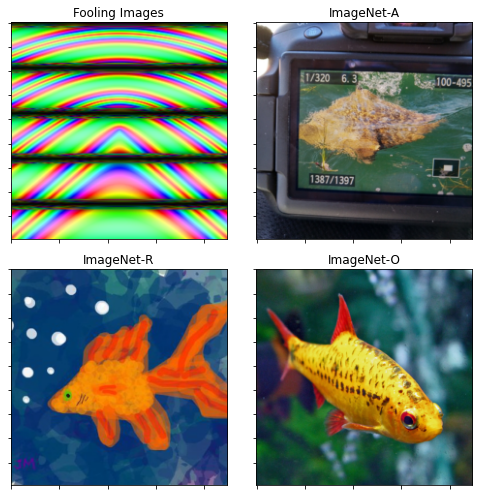

In [93]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
fix, ax = plt.subplots(2,2, figsize=(7,7))
ax = ax.flatten()

ax[0].imshow(to_pil_image(a))
ax[0].axes.yaxis.set_ticklabels([])
ax[0].axes.xaxis.set_ticklabels([])
ax[0].set_title("Fooling Images")

ax[1].imshow(to_pil_image(b))
ax[1].axes.yaxis.set_ticklabels([])
ax[1].axes.xaxis.set_ticklabels([])
ax[1].set_title("ImageNet-A")

ax[2].imshow(to_pil_image(c))
ax[2].axes.yaxis.set_ticklabels([])
ax[2].axes.xaxis.set_ticklabels([])
ax[2].set_title("ImageNet-R")

ax[3].imshow(to_pil_image(d))
ax[3].axes.yaxis.set_ticklabels([])
ax[3].axes.xaxis.set_ticklabels([])
ax[3].set_title("ImageNet-O")

# # disabling xticks by Setting xticks to an empty list
# plt.xticks([])
#
# # disabling yticks by setting yticks to an empty list
# plt.yticks([])

plt.tight_layout()
plt.savefig("/home/ki/examples.png", dpi=300)

In [45]:


b.shape

torch.Size([3, 224, 224])

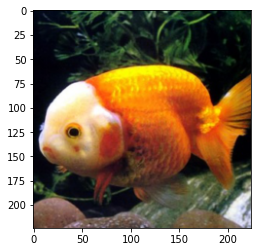

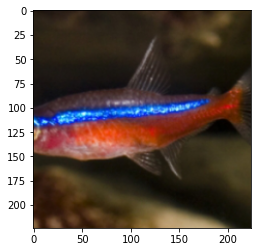

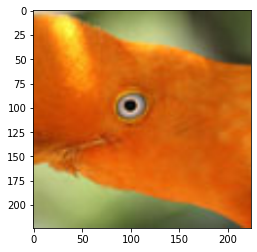

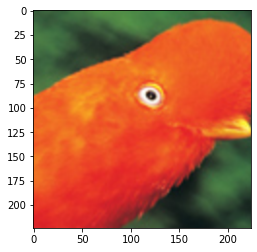

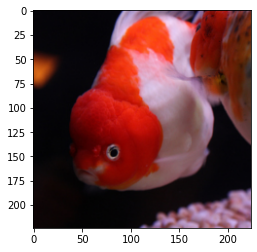

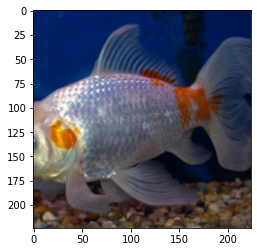

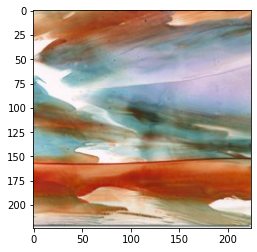

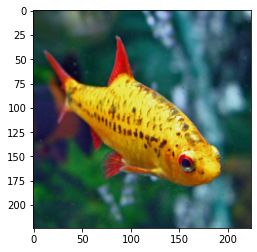

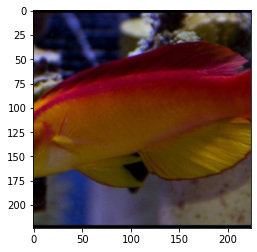

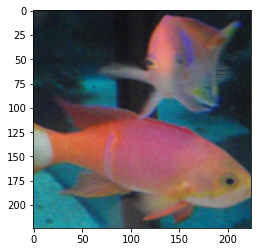

In [73]:

for i in range(0, 10):
    plt.imshow(to_pil_image(dataset_4[i][0]))
    plt.show()

In [90]:

dir(ax[0].axes.xaxis)

['OFFSETTEXTPAD',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_autolabelpos',
 '_axes',
 '_clipon',
 '_clippath',
 '_contains',
 '_copy_tick_props',
 '_default_contains',
 '_format_with_dict',
 '_get_clipping_extent_bbox',
 '_get_tick',
 '_get_tick_bboxes',
 '_get_tick_boxes_siblings',
 '_get_tick_label_size',
 '_get_ticks_position',
 '_gid',
 '_in_layout',
 '_label',
 '_major_tick_kw',
 '_minor_tick_kw',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_remove_overlapping_locs',
 '_scale',
 '_set_artist_props',
 '_set_formatter',
 '_